## Etape 2 : Statistiques descriptives

### Import des librairies et analyse du jeu de données

Import des différentes librairies utiles à l'analyse :

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from datetime import datetime
import time
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as sm
from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant
import gender_guesser.detector as gender

Il est nécessaire d'installer et d'importer "importnb" pour avoir accès aux fonctionns définies dans "algoStatCourse" :

In [2]:
#pip install importnb
#!pip install gender-guesser

In [3]:
from importnb import Notebook
with Notebook():
    import algoStatCourse

Il faut ensuite importer un jeu de donnée. On prend le jeu de données correspondant aux 10 kilomètres de Riorges comme exemple pour l'analyse dans ce document :

In [4]:
data=pd.read_csv("10_km_Riorges.csv")

Comme chaque jeu de données extrait, nous avons à notre disponibilité le nom et prénom de chaque athlète, leur performance, leur années de naissance, la catégorie à laquelle ils appartiennent, leur temps, ainsi que leur écart de temps avec le premier.

In [5]:
data.head()

,Athlète,Ligue,Performance,Naissance,Catégorie,time_delta,time_gap,duration,Nom,Prénom
0,LORTON Guillaume,ARA,N4,1989,SEM,0 days 00:30:58,0 days 00:00:00,1858.0,LORTON,Guillaume
1,BETRON Adrien,ARA,IR1,1989,SEM,0 days 00:31:30,0 days 00:00:32,1890.0,BETRON,Adrien
2,MOULIN Loic,ARA,IR2,1992,SEM,0 days 00:32:01,0 days 00:01:03,1921.0,MOULIN,Loic
3,DEBROUCKER Guillaume,ARA,IR2,1982,M1M,0 days 00:32:15,0 days 00:01:17,1935.0,DEBROUCKER,Guillaume
4,KEMEI Charles,ARA,IR2,1984,M0M,0 days 00:32:40,0 days 00:01:42,1960.0,KEMEI,Charles


In [6]:
data[data['Prénom']=='Vincent']
print(data[data['Catégorie']=='M6F'])
data.groupby('Catégorie').count()

          Athlète Ligue Performance  Naissance Catégorie       time_delta  \
224  JULIEN Annie     0          D7       1957       M6F  0 days 00:58:57   

            time_gap  duration     Nom Prénom  
224  0 days 00:27:59    3537.0  JULIEN  Annie  


,Athlète,Ligue,Performance,Naissance,time_delta,time_gap,duration,Nom,Prénom
Catégorie,,,,,,,,,
CAF,2,2,2,2,2,2,2,2,2
CAM,3,3,3,3,3,3,3,3,3
ESF,3,3,3,3,3,3,3,3,3
ESM,8,8,8,8,8,8,8,8,8
JUF,2,2,2,2,2,2,2,2,2
JUM,5,5,5,5,5,5,5,5,5
M0F,9,9,9,9,9,9,9,9,9
M0M,22,22,22,22,22,22,22,22,22
M1F,11,11,11,11,11,11,11,11,11


On ajoute la variable 'h_duration' qui permet d'obtenir le temps d'arrivée dans le format heures, minutes, secondes, afin d'avoir une variable explicite pour la visualisation.

In [7]:
data['h_duration'] = data['duration'].apply(lambda x : pd.to_datetime(x,unit="s").strftime('%H:%M:%S'))

Nous analysons maintenant les statistiques descriptives du temps d'arrivée afin de connaitre rapidement la forme des données, et la présence de possible valeurs abérantes, pour guider la construction des visualisations utile à l'athlète. Dans ce jeu de données, nous n'avons à première vue pas de potentiels valeurs abbérantes étant données que les temps sont environ réparti entre 30 et 70 mn, temps normaux pour une course de 10 km.

In [8]:
(data['duration']/60).describe()

count    250.000000
mean      46.830600
std        8.432333
min       30.966667
25%       39.666667
50%       46.158333
75%       52.758333
max       70.750000
Name: duration, dtype: float64

### Construction des visualisations et données utiles à l'athlète

On utilise maintenant algoStatCourse pour construire un graphique rendant compte de la position de l'athlète dans la densité des temps d'arrivée.

In [9]:
# densite=algoStatCourse.dens(data['duration'], bins = 12) #Calcul de la densité de la variable 'duration'
# fcubic=algoStatCourse.lissage(densite, sep = True) #Retourne la fonction d'interpolation cubique
# flin=algoStatCourse.lissage(densite, sep = False, kind = 'linear') #Retourne la fonction d'interpolation linéaire

On définit une fonction qui permet d'appliquer une indicatrice afin de retourner la partie de la fonction qui nous intéresse. Cela sera utile pour mettre en avant les athlètes plus rapides qu'un athlète donné dans la distribution des temps.

In [10]:
def truncf (f,xmin, xmax):
    def f2 (x):
        if (x>=xmin)*(x<=xmax):
            return f(x)
        return np.nan
    
    return np.vectorize(f2)

Il est maintenant possible de définir une fonction pour visualiser la position individuelle de l'athlète dans la densité de temps de la compétition.

In [11]:
def graphePerso(prenom, nom, data, titre):
    
    densite=algoStatCourse.dens(data['duration'], bins = algoStatCourse.idealBins(len(data['duration']))) #Calcul de la densité de la variable 'duration'
    #print(densite)
    fcubic=algoStatCourse.lissage(densite, sep = True,beginend = (data['duration'].min(),data['duration'].max())) #Retourne la fonction d'interpolation cubique
    flin=algoStatCourse.lissage(densite, sep = False, kind = 'linear', beginend = (data['duration'].min(),data['duration'].max())) #Retourne la fonction d'interpolation linéaire
    
    z=data.index[data.Athlète==(nom.upper()+" "+prenom.capitalize())] #numéro de l'index du participant
    
    temps = data.loc[z[0],'duration'] #temps du participant
    
    x= np.linspace(data['duration'].min(),data['duration'].max(), int(1e5)) #x permet d'obtenir un tracé continu

    tempsAxe = np.linspace(densite[0,0],densite[0,-1],6) #définition de l'axe des abscisses en secondes avec 6 points
    labelTempsAxe = pd.Series(tempsAxe).apply(lambda x : pd.to_datetime(x,unit="s").strftime('%H:%M:%S')) #Définition de la forme que prendra le temps sur l'axe des abcisses (format heures/minutes/secondes pour plus de lisibilité)

    plt.figure(figsize=(8,4.5), dpi=80) #format de la figure, (dpi pour la résolution)
    plt.fill_between(x, fcubic(x), alpha = 0.3) #fonction pour colorier l'aire sous la courbe
    plt.plot(x, fcubic(x), color = 'blue', label = 'densité lissée & interpolée')

    #plt.plot(x,flin(x), linestyle ='--', color = 'black', label = "densité réelle") #possibilité de dessiner l'interpolation linéaire au lieu de l'interpolation cubique

    plt.axvline(temps, color='r',alpha=0.3) #ligne verticale pour indiquer la position du participant sur les abscisses

    f2=truncf(fcubic,data['duration'].min(), temps) #on tronque fcubic pour ne retenir que la partie de la fonction des temps meilleurs à celui de l'individu
    plt.fill_between(x,f2(x), alpha = 0.6, color = 'red') #on affiche l'aire des temps meilleurs à celui de l'individu en rouge

    #plt.axvspan(temps, densite[0,0], color='r', alpha=0.3)
    plt.legend() #permet d'afficher les légendes qu'on a mises dans les arguments 'label' des fonctions juste au dessus

    # Ajout des labels et titre
    plt.title(titre, color= 'tab:red', fontsize = '15', fontstyle = 'oblique') # titre
    plt.xlabel("Durée pour franchir la ligne d'arrivée", fontstyle = 'italic', labelpad=5) #label abscisse
    plt.ylabel("Densité des athlètes", fontstyle = 'italic', labelpad=20) #label ordonnée
    #plt.xticks(tempsAxe,labels = labelTempsAxe) #permet de choisir ce qu'on met sur l'axe des x : les coordonnées dans le premier argument, ce qu'il faut afficher dans le second.
    plt.ylim((-0.1*max(densite[1]),1.1*max(densite[1]))) #permet de choisir l'espace au dessus et au dessous du graphe
    plt.text(data.loc[z[0],'duration'],0.0001,data.loc[z[0],'Prénom'] ) # ajoute un texte directement sur le graphe
    plt.show()
    return

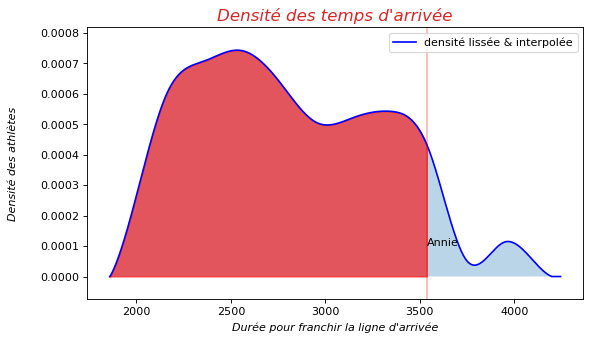

In [12]:
graphePerso("annie","julien", data=data,titre = "Densité des temps d'arrivée")

Test de la fonction graph perso en se restreignant à la catégorie de l'athlète : 

In [13]:
def graphePerso2(prenom, nom, data=data):
    z=data.index[data.Athlète==(nom.upper()+" "+prenom.capitalize())]
    data2=data[data['Catégorie']==data.loc[z[0],'Catégorie']]
    graphePerso(prenom, nom, data=data2, titre = f"Densité des temps d'arrivée dans la catégorie {data.loc[z[0],'Catégorie']}")
               
    return


Cette fonction peut poser des problèmes si peu de d'athlètes sont inscrits dans la catégorie.

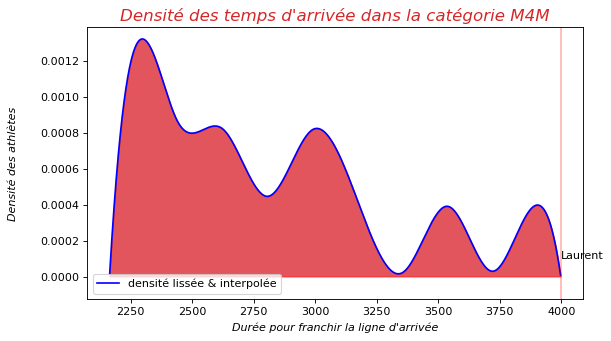

In [14]:
graphePerso2("laurent","surget", data=data)

### Construction et application de l'output des statistiques et visuels individuels

On construit d'abord deux fonctions qui permettront de demander à l'utilisateur son nom et prénom.

In [15]:
def Prenom():
  user_input = input("Veuillez entrer votre prénom")
  return user_input

def Nom():
  user_input = input("Veuillez entrer votre nom")
  return user_input

Ici, on définit une fonction permettant de donner directement les premières informations utile, à partir du nom et prénom, de la performance individuelle relativement à la performance globale de la compétition.

In [16]:
def info_participant():
    x=input("Prenom")
    y=input("Nom")
    if ~data['Athlète'].isin([(y.upper()+" "+x.capitalize())]).any():
        print("Le nom que vous avez entré n'est pas dans la liste des participants de la course choisie.")
    else:
        z=data.index[data.Athlète==(y.upper()+" "+x.capitalize())]
        print("Temps d'arrivé :", data.loc[z[0],'h_duration'])
        print("Position d'arrivée : ", data.index[z[0]]+1)
        print("Niveau de la performance", data.loc[z[0],'Performance'])
        print("Temps d'arrivé dans le top :", math.ceil(((data.duration<=data.loc[z[0],'duration']).sum())/len(data)*100),"%")
        print("Position parmis les", len(data[data['Catégorie']==data.loc[z[0],'Catégorie']]),"participants de la catégorie", data.loc[z[0],'Catégorie'], ":",round(data[data['Catégorie']==data.loc[z[0],'Catégorie']]['duration'].rank().loc[z[0]]))
        print("Position parmis les", len((data[abs(data.loc[:,'Naissance']-data.loc[z[0],'Naissance'])<=5])), "participants ayant plus ou moins 5 ans de différence d'âge avec vous : ", round(((data[abs(data.loc[:,'Naissance']-data.loc[z[0],'Naissance'])<=5])['duration'].rank()).loc[z[0]]))
        graphePerso(x,y,data,titre="Durée pour franchir la ligne d'arrivée")
        if len(data[data['Catégorie']==data.loc[z[0],'Catégorie']])>10:#la fonction graphPerso 2 ne se lance que si il y a un certains nombre d'athlète inscrit dans la catégorie
            graphePerso2(x,y,data)

Exemple d'utilisation:

Prenom charles
Nom kemei


Temps d'arrivé : 00:32:40
Position d'arrivée :  5
Niveau de la performance IR2
Temps d'arrivé dans le top : 2 %
Position parmis les 22 participants de la catégorie M0M : 1
Position parmis les 89 participants ayant plus ou moins 5 ans de différence d'âge avec vous :  4


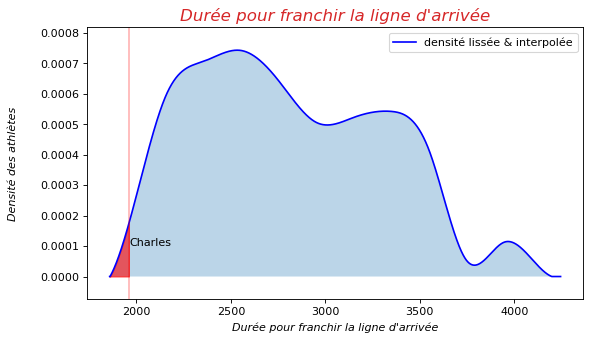

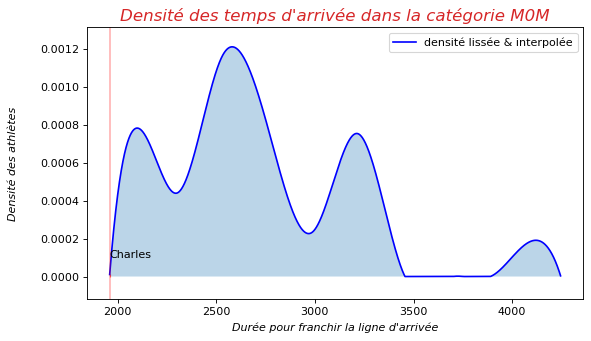

In [38]:
info_participant()

### Information sur la compétition

Construction d'un tableau des podiums :

In [18]:
#Extraction des différentes catégories de la compétition

Catégorie = data['Catégorie'].unique()

# Création d'un dictionaire des temps pour chaque catégorie

dict_catégorie = {}
for x in Catégorie:
    dict_catégorie[x] = data['duration'][data['Catégorie']==x]
    
#Création d'un dataframe avec les catégorie en colonnes et les temps des participants y appartenant en valeur
    
df_catégorie = pd.DataFrame(dict_catégorie)

#Tri des temps pour les 3 premiers temps de chaque catégorie


df1_catégorie=df_catégorie.copy()
for col in df1_catégorie.columns:
    for i in range(3):
        df1_catégorie[col][i] = df_catégorie[col].nsmallest(3).iloc[i]
        
#Extractio des Athlètes correspondants aux 3 premier temps de chaque catégorie
for col in df1_catégorie.columns:
    for i in range(3):
        try:
            df1_catégorie[col][i]=data[['Athlète']][data['duration']==df1_catégorie[col][i]].iloc[0,0]
        except:
            break

#Extraction des 3 premières ligne correspondant au podium
df1_catégorie=df1_catégorie.iloc[:3,:]
df1_catégorie['Podium']=['Premier','Deuxième','Troisième']
df1_catégorie = df1_catégorie.set_index('Podium')
display(df1_catégorie)

/var/folders/jy/77k463fj5d94h9zj3_qn_glh0000gn/T/ipykernel_13889/3476567333.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1_catégorie[col][i]=data[['Athlète']][data['duration']==df1_catégorie[col][i]].iloc[0,0]
/var/folders/jy/77k463fj5d94h9zj3_qn_glh0000gn/T/ipykernel_13889/3476567333.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1_catégorie[col][i]=data[['Athlète']][data['duration']==df1_catégorie[col][i]].iloc[0,0]
/var/folders/jy/77k463fj5d94h9zj3_qn_glh0000gn/T/ipykernel_13889/3476567333.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the cav

,SEM,M1M,M0M,M3M,ESM,JUM,M4M,M2M,M5M,M1F,...,M7M,JUF,M3F,M5F,CAF,M4F,M8M,M0F,M6F,M8F
Podium,,,,,,,,,,,,,,,,,,,,,
Premier,LORTON Guillaume,DEBROUCKER Guillaume,KEMEI Charles,BUISSON Antoine,PETRAS Guillaume,BOYER Theo,MAHAMDI Ahmed,ANGELI Stephane,CARVELLI Salvatore,LECOMTE Claire,...,ARNAL Jean,MERAT Audrey,PITAVY Lydia,CUBIZOLLES Martine,DJIGO Rosane,GOUREAU Lucie,MASTON Walter,QUENOT Marie,JULIEN Annie,REURE Michele
Deuxième,BETRON Adrien,SPIMOLA MARQUES,CROUE Jeremy,DEFOUS Stephane,DOUCET Thomas,TACHET Alexis,CHADEBEC Patrick,PONCHON Freddy,VASSAL Fabrice,BENIGAUD Aurelien,...,LOMBARD Joseph,GORDONS Ines,NaN,VIAL Bruno,BESSON Agathe,PROMONET Nelly,NaN,COUTO Celine,NaN,NaN
Troisième,MOULIN Loic,TACHET Alexis,REBOUL Samuel,GIRAUDIER Francois,PERRAUD Victor,MILLY Corentin,CHAMPALLE Thierry,SPITALIERI Patrick,BELGUERRI Nordine,THEVENON Aurelie,...,RISI Xavier,NaN,NaN,NaN,NaN,NaN,NaN,THOMAS Marie,NaN,NaN


### Pistes de recherches

In [39]:
df1=data.groupby('Naissance').mean().reset_index()

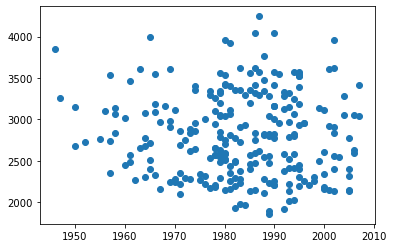

In [47]:
y=data['duration'].to_numpy()
x=data['Naissance'].to_numpy()
plt.scatter(x,y)

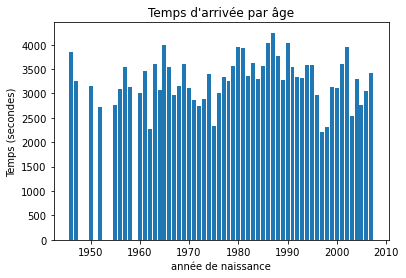

In [49]:
plt.bar(x, y)
plt.xlabel("année de naissance")
plt.ylabel('Temps (secondes)')
plt.title("Temps d'arrivée par âge")
plt.show()

On peut utiliser l'indice de silhouette pour évaluer la qualité des clusters. Cet indice mesure la distance entre les points d'un cluster et la moyenne de tous les autres clusters, ce qui vous permet de déterminer si les points d'un cluster sont bien regroupés ou s'ils sont dispersés. Plus l'indice de silhouette est élevé, mieux c'est.

Avec cet indice, on peut trouver le nombre de clusters qui donne les meilleures performances en termes de qualité des clusters.

In [50]:
data_set=np.dstack((x,y))[0]
model = KMeans(2).fit(data_set)

In [51]:
# Nombre de cluster à tester :
num_clusters = [2, 3, 4, 5, 6]

# Méthode KMeans en spécifiant différents nombres de clusters
for n in num_clusters:
    kmeans = KMeans(n_clusters=n)
    kmeans.fit(data_set)
    
    # Utilisation de l'indice de silhouette pour évaluer la qualité des clusters
    silhouette_avg = metrics.silhouette_score(data_set, kmeans.labels_)
    print("Pour n_clusters =", n, "Le score de silhouette moyen est :", silhouette_avg)

Pour n_clusters = 2 Le score de silhouette moyen est : 0.6093582934670067
Pour n_clusters = 3 Le score de silhouette moyen est : 0.5667367025320953
Pour n_clusters = 4 Le score de silhouette moyen est : 0.5514808363696325
Pour n_clusters = 5 Le score de silhouette moyen est : 0.5705770699675163
Pour n_clusters = 6 Le score de silhouette moyen est : 0.5586425716750582


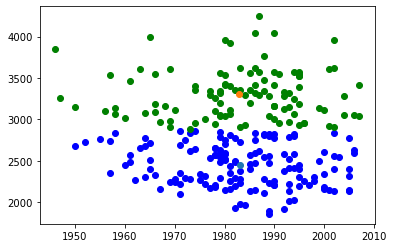

In [52]:
for point in data_set:
    if model.predict(point.reshape(1,-1)) == [0]:
        plt.scatter(point[0], point[1], c='b')
    elif model.predict(point.reshape(1,-1)) == [1]:
        plt.scatter(point[0], point[1], c='g')

     
for center in model.cluster_centers_:
    plt.scatter(center[0],center[1])

plt.show()

In [53]:
model = KMeans(5).fit(data_set)

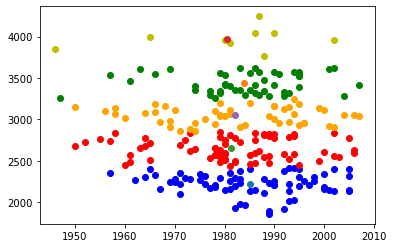

In [54]:
for point in data_set:
    if model.predict(point.reshape(1,-1)) == [0]:
        plt.scatter(point[0], point[1], c='b')
    elif model.predict(point.reshape(1,-1)) == [1]:
        plt.scatter(point[0], point[1], c='g')
    elif model.predict(point.reshape(1,-1)) == [2]:
        plt.scatter(point[0], point[1], c='r')
    elif model.predict(point.reshape(1,-1)) == [3]:
        plt.scatter(point[0], point[1], c='y')
    elif model.predict(point.reshape(1,-1)) == [4]:
        plt.scatter(point[0], point[1], c='orange')
     
for center in model.cluster_centers_:
    plt.scatter(center[0],center[1])

plt.show()

A travers cette analyse de cluster on ne retrouve pas de différence notable d'âge entre cluster visuellement.model. On peut voir les centroïde de chaque cluster (affiché dans une couleur différente de celle du cluster). Ceux-ci sont tous entre 1980, et 1984.

In [56]:
pd.DataFrame(model.cluster_centers_, columns=(['Naissance','temps']))

,Naissance,temps
0,1985.128571,2221.842857
1,1983.979167,3438.312500
2,1981.263889,2648.138889
3,1980.555556,3974.888889
4,1982.019608,3048.058824


Testons si une régression linéaire prédit un effet de l'âge sur le résultat.

In [57]:
X = add_constant(x)
regression = OLS(y, X).fit() 

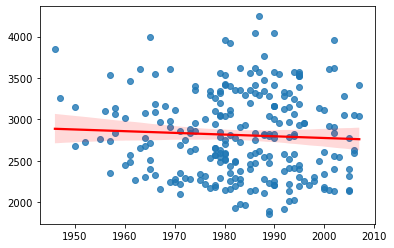

In [59]:
# Tracer un nuage de points avec la droite de régression
sns.regplot(x=x, y=y, line_kws={"color": "red"})
plt.show()

In [60]:
regression.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.6955
Date:                Sun, 18 Dec 2022   Prob (F-statistic):              0.405
Time:                        23:09:49   Log-Likelihood:                -1910.5
No. Observations:                 250   AIC:                             3825.
Df Residuals:                     248   BIC:                             3832.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       6891.7454   4894.572      1.408      0.160   -2748.485    1.65e+04
x1            -2.0585      2.468     -0.834      0.405      -6.920       2.803
==============================================================================
Omnibus:                       13.444   Durbin-Watson:                   0.007
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               10.006
Skew:                           0.381   Prob(JB):                      0.00672
Kurtosis:                       2.383   Cond. No.                     3.03e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.03e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Vérifions ex-post les hypothèses de Gauss-Markov:

1. Le coefficient de 'Naissance' n'est pas statistiquement significatif. L'hypothèse de linéarité n'est donc pas respecté. 
2. Les erreurs ne suivent pas une loi normale au seuil de confiance de 1 % selon la statistique de Jarque-Bera.
3. D'après le nuage de point, la variance des erreurs semble ne pas être constante. Les points sont moins dispersés aux extrémités.
4. Il est généralement recommandé de considérer que l'hypothèse d'indépendance des erreurs est vérifiée lorsque la valeur de Durbin-Watson est comprise entre 1,5 et 2,5. Elle en est trés éloigné ici. L'hypothèse d'indépendance des erreurs est donc rejetée.

La régression n'est pas satisfaisante (R^2 très faible et coefficient non significatif) et les hypothèses de Gauss-Markov ne sont pas satisfaites.

On décide d'explorer l'ajout d'une variable 'sexe' dans la régression. Pour cela on utilise qui permet de prédire le sexe à partir du prénom sur la base de la fréquence.

In [31]:
detector = gender.Detector()
sexe = detector.get_gender("John")
data['sexe'] = data['Prénom'].apply(lambda x : detector.get_gender(x))

Certains prénoms sont inconnus, peut-être à cause de soucis d'accent ou de scrapping. on se concentrera dans l'analyse sur les individus dont le sexe est soit 'male', soit 'female', c'est à dire ceux dont le sexe a une probabilité importante d'être correctement prédit.

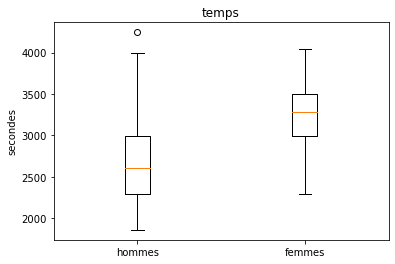

In [32]:
plt.boxplot([data['duration'][data['sexe']=='male'], data['duration'][data['sexe']=='female']], labels=['hommes', 'femmes'])
plt.title('temps')
plt.ylabel('secondes')
plt.show()

In [62]:
data1=data[(data['sexe']=='male') | (data['sexe']=='female')]

In [64]:
data1['sexe'] = data1['sexe'].replace({'male': 0, 'female': 1})

/var/folders/jy/77k463fj5d94h9zj3_qn_glh0000gn/T/ipykernel_13889/1310617123.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1['sexe'] = data1['sexe'].replace({'male': 0, 'female': 1})


In [65]:
X=data1[['sexe','Naissance']]
X['constante']=1
X=X.to_numpy()
y=data1['duration'].to_numpy()

/var/folders/jy/77k463fj5d94h9zj3_qn_glh0000gn/T/ipykernel_13889/206699885.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['constante']=1


In [66]:
regression = OLS(y, X).fit() 

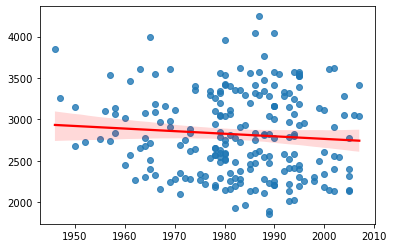

In [67]:
sns.regplot(x=data1['Naissance'].to_numpy(), y=y, line_kws={"color": "red"})
plt.show()

In [68]:
regression.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.228
Model:                            OLS   Adj. R-squared:                  0.221
Method:                 Least Squares   F-statistic:                     32.33
Date:                Sun, 18 Dec 2022   Prob (F-statistic):           5.00e-13
Time:                        23:18:14   Log-Likelihood:                -1666.9
No. Observations:                 222   AIC:                             3340.
Df Residuals:                     219   BIC:                             3350.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1           542.3290     68.423      7.926      0.000     407.478     677.180
x2            -6.1389      2.338     -2.625      0.009     -10.747      -1.530
const       1.485e+04   4633.312      3.204      0.002    5713.874     2.4e+04
==============================================================================
Omnibus:                       11.412   Durbin-Watson:                   0.444
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               11.688
Skew:                           0.542   Prob(JB):                      0.00290
Kurtosis:                       3.300   Cond. No.                     3.08e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.08e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

L'ajout su sexe comme variable explicative semble être utile pour expliquer le temps d'arrivée des athlètes car le R^2 a significativement augmenté. Les coefficients des variables 'sexe' et 'Naissance' sontt de plus tous les deux statistiquement significatif. Etre une femme prédit un temps d'arrivée d'environ 9 minutes plus long toute chose égale par ailleurs. De plus, être né une année plus tard prédit une performance d'environ 6 secondes meilleures.

Le coefficient estimé de la variable 'Naissance' a diminué dans ce second modèle. Il se pourrait donc qu'il y ait un biais d'ommission lié à la variable 'sexe' dans le premier modèle. C'est le cas si le sexe et l'âge sont liés. A priori ces deux variables sont indépendantes. Toutefois, il se pourrait que les femmes se soient intégrées dans l'athlètisme que récemment. Il pourrait y avoir alors une moyenne d'âge plus jeune chez les femmes que chez les femmes et donc un biais d'omission.

In [70]:
data.Naissance[(data['sexe']=='male')].mean()

1981.4171779141104

In [71]:
data.Naissance[(data['sexe']=='female')].mean()

1986.1864406779662